# KNN 

# 1. Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import ExtraTreesClassifier

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

# 2. Dataset

In [3]:
dataset = pd.read_csv('../../Data/adult.csv')
display(dataset.head(5))

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
dataset.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

## 2.1 Analising columns values
No line seems to have Nan or empty values. However futher investigation is needed once it's already possible to see '?' values in different columns. 

In [6]:
print("Work class categories \n")
print(dataset['workclass'].unique())

Work class categories 

['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']


In [7]:
print("Education categories")
education_dataset = dataset[['education','education.num']]
education_dataset = education_dataset.drop_duplicates()

data = {'education': education_dataset['education'], 'education.num': education_dataset['education.num']}

education_dataset = pd.DataFrame(data=data)
education_dataset['education'].astype('category')
education_dataset.index = education_dataset['education.num']
print(education_dataset[['education']].sort_values('education.num'))

Education categories
                  education
education.num              
1                 Preschool
2                   1st-4th
3                   5th-6th
4                   7th-8th
5                       9th
6                      10th
7                      11th
8                      12th
9                   HS-grad
10             Some-college
11                Assoc-voc
12               Assoc-acdm
13                Bachelors
14                  Masters
15              Prof-school
16                Doctorate


The columns 'education' and 'education.num' represent the same information. 'education.num' is the respective label for an education level. 

In [8]:
print('marital status')
print(dataset['marital.status'].unique())
print(' \n occupation')
print(dataset['occupation'].unique())
print(' \n relationship')
print(dataset['relationship'].unique())
print(' \n race')
print(dataset['race'].unique())
print(' \n native.country')
print(dataset['native.country'].unique())


marital status
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
 
 occupation
['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
 
 relationship
['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']
 
 race
['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
 
 native.country
['United-States' '?' 'Mexico' 'Greece' 'Vietnam' 'China' 'Taiwan' 'India'
 'Philippines' 'Trinadad&Tobago' 'Canada' 'South' 'Holand-Netherlands'
 'Puerto-Rico' 'Poland' 'Iran' 'England' 'Germany' 'Italy' 'Japan' 'Hong'
 'Honduras' 'Cuba' 'Ireland' 'Cambodia' 'Peru' 'Nicaragua'
 'Dominican-Republic' 'Haiti' 'El-Salvador' 'Hungary' 'Columbia'
 'Guatemala' 'Jamaica' 'Ecuador' 'France' 'Yugoslavia' 'Scotland'
 'Portugal' 'Laos'

## 2.2 Dataset cleaning

As mentioned before, in many columns are present the '?' value for a missing information. So it will be removed every observation that contains a missing value. Also, it will be removed the columns 'capital.gain' and 'capital.loss', which doesn't seem so clear its meaning, and 'fnlwgt' which represents some final avaliation about the observation, thus the fitting process will get an equal result.

In [9]:
#Replacing ? for a nan value to drop every line with it
dataset = dataset.replace({'?': np.nan})
dataset = dataset.dropna()
dataset = dataset.drop(['fnlwgt', 'capital.gain','capital.loss'], axis=1)

# 3. EDA

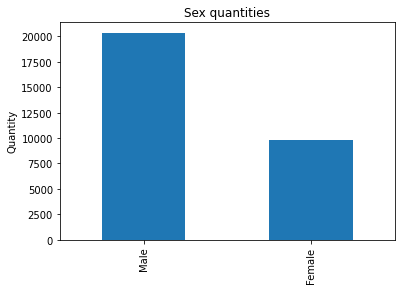

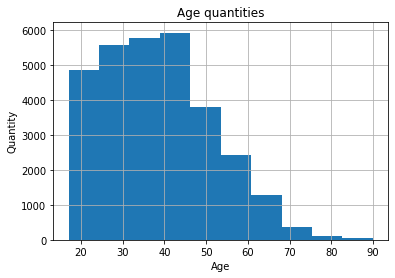

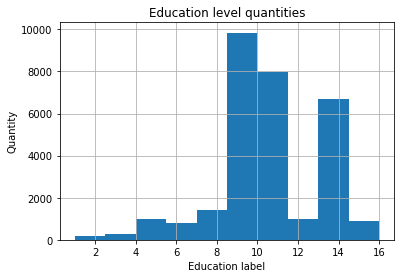

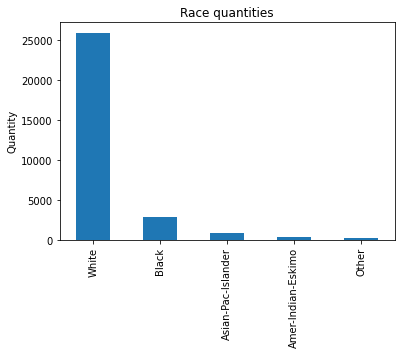

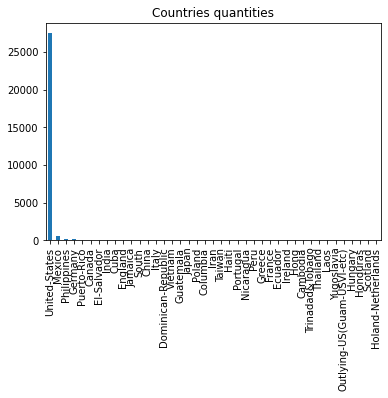

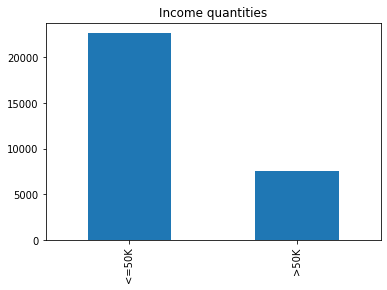

In [10]:
ax = dataset['sex'].value_counts().plot(kind="bar")
ax.set_ylabel("Quantity")
plt.title("Sex quantities")
plt.show()

ax = dataset['age'].hist()
ax.set_xlabel("Age")
ax.set_ylabel("Quantity")
plt.title("Age quantities")
plt.show()

ax = dataset['education.num'].hist()
ax.set_xlabel("Education label")
ax.set_ylabel("Quantity")
plt.title("Education level quantities")
plt.show()

ax = dataset['race'].value_counts().plot(kind="bar")
ax.set_ylabel("Quantity")
plt.title("Race quantities")
plt.show()

dataset['native.country'].value_counts().plot(kind="bar")
ax.set_ylabel("Quantity")
plt.title("Countries quantities")
plt.show()

dataset['income'].value_counts().plot(kind="bar")
ax.set_ylabel("Quantity")
plt.title("Income quantities")
plt.show()

# 4. Fitting a model

In [11]:
#Preparing the features and target
features = dataset.drop("income", axis=1)
target = dataset.income

#encoding the category features
features_to_encode = features[['workclass', 'education', 'marital.status',
       'occupation', 'relationship', 'race', 'sex',
       'native.country']]

features_encoded = features_to_encode.apply(preprocessing.LabelEncoder().fit_transform)
target = preprocessing.LabelEncoder().fit_transform(target)
features[['workclass', 'education', 'marital.status',
       'occupation', 'relationship', 'race', 'sex',
       'native.country']] = features_encoded

print(features.shape, target.shape)

display(features.head(5))

(30162, 11) (30162,)


,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country
1,82,2,11,9,6,3,1,4,0,18,38
3,54,2,5,4,0,6,4,4,0,40,38
4,41,2,15,10,5,9,3,4,0,40,38
5,34,2,11,9,0,7,4,4,0,45,38
6,38,2,0,6,5,0,4,4,1,40,38


In [12]:
#Dividing train and test data
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.3)

In [12]:
#Analising the % importance level in each feature
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
forest.fit(features, target)
importances = forest.feature_importances_
feature_importances = pd.DataFrame(importances*100,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
display(feature_importances)

,importance
age,26.506240
hours.per.week,14.746229
education.num,10.760729
occupation,10.709608
relationship,10.678339
marital.status,8.740089
workclass,5.967166
education,4.437990
sex,3.332022
native.country,2.164723


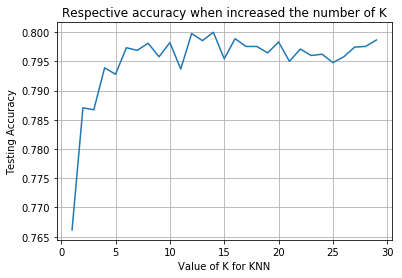

In [13]:
#Analisng the accuracy by increasing the number of K
scores = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

sns.lineplot(range(1,30), scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title("Respective accuracy when increased the number of K")
plt.grid(True)
plt.show()

In [14]:
print("The best K value in this dataset is {0} - Accuracy = {1}".format(scores.index(max(scores)), max(scores)))

The best K value in this dataset is 13 - Accuracy = 0.7999778981102884


## Fairness

In [14]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [15]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [16]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [18]:
dataset['income']=dataset['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
features['income'] = dataset.income
features

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income
1,82,2,11,9,6,3,1,4,0,18,38,0
3,54,2,5,4,0,6,4,4,0,40,38,0
4,41,2,15,10,5,9,3,4,0,40,38,0
5,34,2,11,9,0,7,4,4,0,45,38,0
6,38,2,0,6,5,0,4,4,1,40,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,2,15,10,4,10,1,4,1,40,38,0
32557,27,2,7,12,2,12,5,4,0,38,38,0
32558,40,2,11,9,2,6,0,4,1,40,38,1
32559,58,2,11,9,6,0,4,4,0,40,38,0


In [19]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = StandardDataset(features,
                                  label_name='income',
                                  protected_attribute_names=['sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])


In [20]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.200159


In [21]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 250

model = ExtraTreesClassifier(n_estimators=250,random_state=0)


mdl = model.fit(X_train, y_train)
with open('../../Results/ExtraTrees/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/ExtraTrees/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/ExtraTrees/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [22]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = ExtraTreesClassifier(n_estimators=i, random_state=0)

    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [23]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
print(final_result)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/ExtraTrees/' + nb_fname + '.csv')
final_result

       0         1         2         3         4         5
0      1 -0.193717 -0.088546  0.107385  0.358240  0.156897
1      2 -0.158251 -0.105207  0.099070  0.305132  0.177942
2      3 -0.188583 -0.097876  0.105711  0.345752  0.153081
3      4 -0.170619 -0.085252  0.093289  0.325594  0.164190
4      5 -0.187544 -0.062743  0.090209  0.350834  0.151774
..   ...       ...       ...       ...       ...       ...
245  246 -0.190805 -0.105171  0.108043  0.324989  0.149173
246  247 -0.191297 -0.106214  0.108684  0.324424  0.148949
247  248 -0.190313 -0.105171  0.107685  0.325556  0.149081
248  249 -0.191461 -0.107256  0.109086  0.324237  0.148663
249  250 -0.191483 -0.111895  0.111166  0.322591  0.149112

[250 rows x 6 columns]


,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T240,T241,T242,T243,T244,T245,T246,T247,T248,T249
accuracy,0.804398,0.781744,0.791469,0.794784,0.797436,0.796000,0.801746,0.801746,0.802409,0.803846,...,0.804177,0.804398,0.804288,0.804288,0.803956,0.804177,0.804288,0.804509,0.804619,0.804398
f1,0.584897,0.554277,0.511772,0.570437,0.548188,0.573869,0.566248,0.582985,0.570605,0.584795,...,0.585012,0.584702,0.584954,0.584565,0.584543,0.584623,0.585149,0.585034,0.585948,0.584897
statistical_parity_difference,-0.191483,-0.193717,-0.158251,-0.188583,-0.170619,-0.187544,-0.174016,-0.186649,-0.174081,-0.182725,...,-0.190958,-0.189646,-0.190466,-0.190313,-0.191461,-0.190805,-0.191297,-0.190313,-0.191461,-0.191483
equal_opportunity_difference,-0.111895,-0.088546,-0.105207,-0.097876,-0.085252,-0.062743,-0.068929,-0.071837,-0.060978,-0.066391,...,-0.106214,-0.104650,-0.105692,-0.104650,-0.105692,-0.105171,-0.106214,-0.105171,-0.107256,-0.111895
average_abs_odds_difference,0.111166,0.107385,0.099070,0.105711,0.093289,0.090209,0.085960,0.092036,0.082052,0.087186,...,0.108492,0.107112,0.107992,0.107544,0.108663,0.108043,0.108684,0.107685,0.109086,0.111166
disparate_impact,-1.131371,-1.026553,-1.187010,-1.062033,-1.122103,-1.047442,-1.084968,-1.061997,-1.062977,-1.050385,...,-1.122019,-1.117376,-1.120281,-1.122222,-1.126281,-1.123964,-1.125703,-1.122222,-1.126281,-1.131371
theil_index,0.149112,0.156897,0.177942,0.153081,0.164190,0.151774,0.157219,0.149159,0.155383,0.148974,...,0.148979,0.149209,0.149046,0.149239,0.149137,0.149173,0.148949,0.149081,0.148663,0.149112
